In [1]:
import numpy as np
import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
train = pd.read_csv('/kaggle/input/credit-score-classification/train.csv', dtype={'Column26': str})

/tmp/ipykernel_33/3648013041.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/kaggle/input/credit-score-classification/train.csv', dtype={'Column26': str})


In [3]:
# That's a tricky one. I loop with extending code, so it solve Data Entry and Data Format issues at once.
train['Age'] = train['Age'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
train['Num_of_Loan'] = train['Num_of_Loan'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
train['Num_of_Delayed_Payment'] = train['Num_of_Delayed_Payment'].fillna('0').str.extract('(\d+)').astype(float).astype(int)

In [4]:
train['Annual_Income'] = train['Annual_Income'].str.replace(r'[^0-9.]', '', regex=True)
train['Annual_Income'] = train['Annual_Income'].astype(float)

In [5]:
# Each column has it's own 'thing', which keep showing me errors. So I will step by step get rid of mistakes until achieving appropriate conditions

train['Changed_Credit_Limit'] = train['Changed_Credit_Limit'].replace('_', np.nan)
train['Changed_Credit_Limit'] = pd.to_numeric(train['Changed_Credit_Limit'], errors='coerce')
train['Changed_Credit_Limit'] = train['Changed_Credit_Limit'].fillna(0)

In [6]:
# As the previous one, here I am dealing with non-numeric values. Conver them into float, ignoring errors. And replacing NaN values with 0

train['Outstanding_Debt'] = train['Outstanding_Debt'].astype(str)
train['Outstanding_Debt'] = train['Outstanding_Debt'].str.replace(r'[^0-9.]', '', regex=True)
train['Outstanding_Debt'] = pd.to_numeric(train['Outstanding_Debt'], errors='coerce')
train['Outstanding_Debt'] = train['Outstanding_Debt'].fillna(0)

In [7]:
# Same but handling more errors

train['Amount_invested_monthly'] = train['Amount_invested_monthly'].astype(str)
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].replace('', '0')
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].str.replace(r'[^0-9.]', '')
train['Amount_invested_monthly'] = pd.to_numeric(train['Amount_invested_monthly'], errors='coerce')
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].fillna(0)

In [8]:
train['Monthly_Balance'] = train['Monthly_Balance'].astype(str)
train['Monthly_Balance'] = train['Monthly_Balance'].str.replace(r'[^0-9.-]+', '')
train['Monthly_Balance'] = pd.to_numeric(train['Monthly_Balance'], errors='coerce')
train['Monthly_Balance'] = train['Monthly_Balance'].fillna(0)

In [9]:
# Covert Credit History Age into Months for better model construction

def parse_years_and_months(age):
    if isinstance(age, str):
        age_parts = age.split(' Years and ')
        years = int(age_parts[0]) if 'Years' in age else 0 
        months_str = age_parts[1].split(' Months')[0] if 'Months' in age_parts[1] else '0' 
        months = int(months_str)
        total_months = years * 12 + months
        return total_months
    else:
        return 0  

train['Credit_History_Age_Months'] = train['Credit_History_Age'].apply(parse_years_and_months)

In [10]:
duplicates = train[train.duplicated()]
num_duplicates = duplicates.shape[0]

if num_duplicates == 0:
    print("There are no duplicates")
else:
    print("There are", num_duplicates, "duplicates.")

There are no duplicates


In [11]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100000.0,119.509700,6.847573e+02,14.000000,25.000000,34.000000,42.000000,8.698000e+03
Annual_Income,100000.0,176415.701298,1.429618e+06,7005.930000,19457.500000,37578.610000,72790.920000,2.419806e+07
Monthly_Inhand_Salary,84998.0,4194.170850,3.183686e+03,303.645417,1625.568229,3093.745000,5957.448333,1.520463e+04
Num_Bank_Accounts,100000.0,17.091280,1.174048e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,100000.0,22.474430,1.290574e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,100000.0,72.466040,4.664226e+02,1.000000,8.000000,13.000000,20.000000,5.797000e+03
Num_of_Loan,100000.0,10.761960,6.178993e+01,0.000000,2.000000,3.000000,6.000000,1.496000e+03
Delay_from_due_date,100000.0,21.068780,1.486010e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Num_of_Delayed_Payment,100000.0,28.779410,2.181148e+02,0.000000,8.000000,13.000000,18.000000,4.397000e+03
Changed_Credit_Limit,100000.0,10.171791,6.880628e+00,-6.490000,4.970000,9.250000,14.660000,3.697000e+01


In [12]:
# Removing rediculous top outliers (2%)

selected_columns_train = train[['Num_Bank_Accounts', 'Interest_Rate', 'Annual_Income', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Total_EMI_per_month', 'Num_of_Loan', 'Num_Credit_Card']]

percentile_threshold = 0.98
percentiles = selected_columns_train.quantile(percentile_threshold)

for column in selected_columns_train.columns:
    train = train[train[column] <= percentiles[column]]

In [13]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,85806.0,120.486003,690.067511,14.000000,25.000000,34.000000,42.000000,8698.000000
Annual_Income,85806.0,49378.620726,36478.390299,7005.930000,19294.460000,36780.030000,70825.760000,166837.640000
Monthly_Inhand_Salary,72894.0,4105.781241,3036.319177,303.645417,1623.778333,3069.091667,5899.970000,14131.123333
Num_Bank_Accounts,85806.0,5.372759,2.585031,-1.000000,3.000000,6.000000,7.000000,10.000000
Num_Credit_Card,85806.0,5.779048,5.727016,0.000000,4.000000,5.000000,7.000000,171.000000
Interest_Rate,85806.0,14.551174,8.824173,1.000000,7.000000,13.000000,20.000000,128.000000
Num_of_Loan,85806.0,7.318381,18.881665,0.000000,2.000000,3.000000,6.000000,100.000000
Delay_from_due_date,85806.0,21.033483,14.786223,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_of_Delayed_Payment,85806.0,12.348321,6.845002,0.000000,8.000000,13.000000,18.000000,25.000000
Changed_Credit_Limit,85806.0,10.189597,6.867078,-6.490000,4.990000,9.280000,14.710000,36.970000


In [14]:
train = train[train['Payment_Behaviour'] != '!@9#%8']

In [15]:
# Drop the rows containing the value '_______' in the 'Occupation' column

train = train[train['Occupation'] != '_______']
print(train['Occupation'].unique())

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


In [16]:
# Drop rows where 'Credit_Mix' is '_'

train = train[train['Credit_Mix'] != '_']
print(train['Credit_Mix'].unique())

['Good' 'Standard' 'Bad']


In [17]:
# Negative values

selected_columns = ['Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Bank_Accounts']

for column in selected_columns:
    train = train[train[column] >= 0]

In [18]:
# Not useful for trainig model

columns_to_drop = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Credit_History_Age','Monthly_Inhand_Salary', 'Type_of_Loan']

train.drop(columns=columns_to_drop, inplace=True)

In [19]:
total_missing_values = train.isnull().sum().sum()

if total_missing_values == 0:
    print("There are no missing values")
else:
    print("Total missing values:", total_missing_values)

There are no missing values


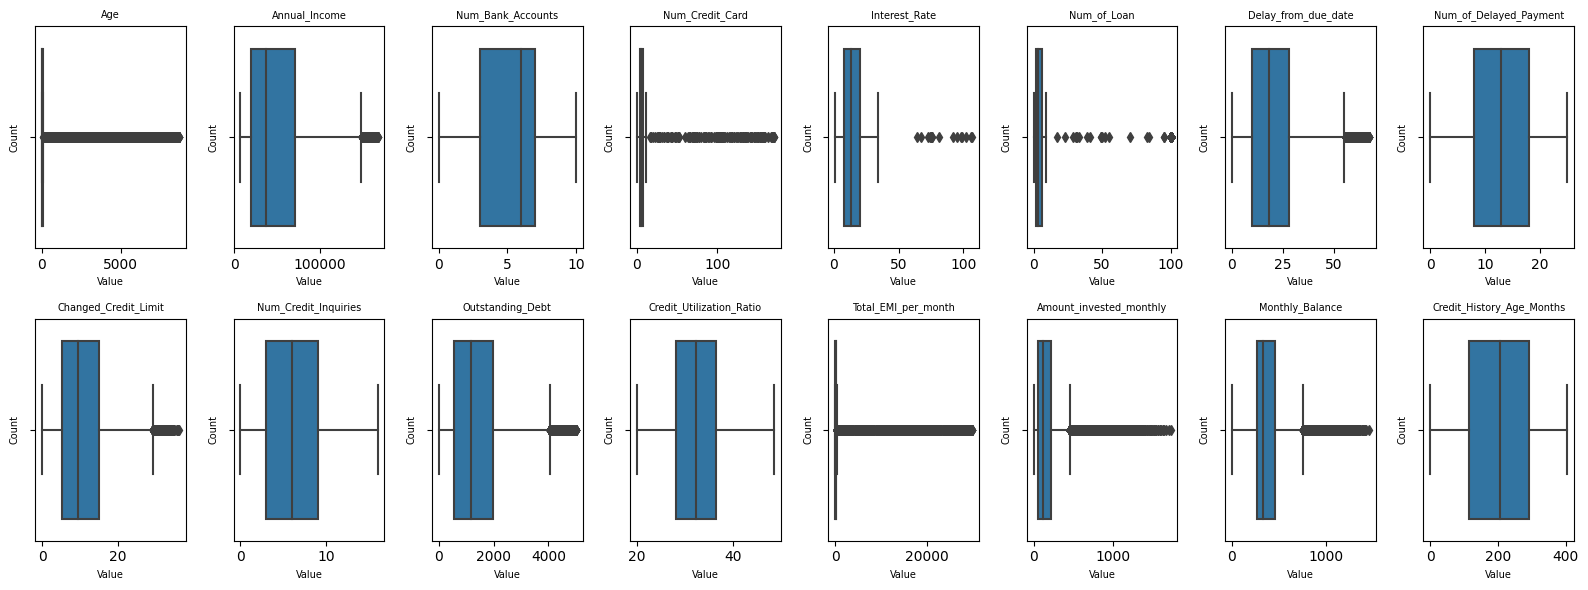

In [20]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns

num_columns = 8
num_rows = (len(numeric_columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 6))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(x=train[column], ax=axes[i])
    axes[i].set_title(column, fontsize=7)  
    axes[i].set_xlabel('Value', fontsize=7)  
    axes[i].set_ylabel('Count', fontsize=7)  

for j in range(len(numeric_columns), num_columns*num_rows):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [21]:
# Another step to tune best scale (subjective)

train = train[train['Age'] < 60]
train = train[train['Num_Credit_Card'] <= 10]
train = train[train['Interest_Rate'] <= 50]
train = train[train['Num_of_Loan'] <= 12]
train = train[train['Num_Bank_Accounts'] <= 10]
train = train[train['Delay_from_due_date'] <= 60]
train = train[train['Changed_Credit_Limit'] <= 30]
train = train[train['Num_Credit_Inquiries'] <= 12]
train = train[train['Total_EMI_per_month'] <= 200]
train = train[train['Outstanding_Debt'] <= 1500]

In [22]:
categories = ['Poor', 'Standard', 'Good']

encoder = OrdinalEncoder(categories=[categories])

train['Credit_Score_Encoded'] = encoder.fit_transform(train[['Credit_Score']])

In [23]:
# Encoding Occupation

label_encoder = LabelEncoder()
train['Occupation_Encoded'] = label_encoder.fit_transform(train['Occupation'])

In [24]:
categories = ['Bad', 'Standard', 'Good']

encoder = OrdinalEncoder(categories=[categories])

train['Credit_Mix_Encoded'] = encoder.fit_transform(train[['Credit_Mix']])

In [25]:
categories_payment_behaviour = [
    'Low_spent_Small_value_payments', 
    'Low_spent_Medium_value_payments', 
    'Low_spent_Large_value_payments', 
    'High_spent_Small_value_payments', 
    'High_spent_Medium_value_payments', 
    'High_spent_Large_value_payments'
]

encoder_payment_behaviour = OrdinalEncoder(categories=[categories_payment_behaviour])

train['Payment_Behaviour_Encoded'] = encoder_payment_behaviour.fit_transform(train[['Payment_Behaviour']])

In [26]:
columns_to_drop = [ 'Payment_Behaviour', 'Credit_Mix', 'Occupation','Credit_Score']
train.drop(columns=columns_to_drop, inplace=True)

In [27]:
# Calculate the total number of accounts (Bank Accounts + Credit Cards)

train['Total_Num_Accounts'] = train['Num_Bank_Accounts'] + train['Num_Credit_Card']

# Calculate the total outstanding debt per account

train['Debt_Per_Account'] = train['Outstanding_Debt'] / train['Total_Num_Accounts']

# Calculate the ratio of outstanding debt to annual income

train['Debt_to_Income_Ratio'] = train['Outstanding_Debt'] / train['Annual_Income']

# Calculate the total number of delayed payments per account

train['Delayed_Payments_Per_Account'] = train['Num_of_Delayed_Payment'] / train['Total_Num_Accounts']

# Calculate the total monthly expenses (EMI + Monthly Investments) 

train['Total_Monthly_Expenses'] = train['Total_EMI_per_month'] + train['Amount_invested_monthly']

In [28]:
categorical_columns = train.select_dtypes(include=['object']).columns

data_encoded = train.copy()

encoder = OrdinalEncoder()
data_encoded[categorical_columns] = encoder.fit_transform(data_encoded[categorical_columns])

y = data_encoded['Credit_Score_Encoded']
X = data_encoded.drop(columns=['Credit_Score_Encoded'])

mi_scores = mutual_info_classif(X, y)

for i, score in enumerate(mi_scores):
    print(f"Feature '{X.columns[i]}': Mutual Information Score = {score}")

Feature 'Age': Mutual Information Score = 0.005355766344456336
Feature 'Annual_Income': Mutual Information Score = 0.4278383608612326
Feature 'Num_Bank_Accounts': Mutual Information Score = 0.055919051433099165
Feature 'Num_Credit_Card': Mutual Information Score = 0.07094135915352862
Feature 'Interest_Rate': Mutual Information Score = 0.09910684022406446
Feature 'Num_of_Loan': Mutual Information Score = 0.017929741244085085
Feature 'Delay_from_due_date': Mutual Information Score = 0.06626257714179906
Feature 'Num_of_Delayed_Payment': Mutual Information Score = 0.049976118842840034
Feature 'Changed_Credit_Limit': Mutual Information Score = 0.10661768339763089
Feature 'Num_Credit_Inquiries': Mutual Information Score = 0.030226760939608743
Feature 'Outstanding_Debt': Mutual Information Score = 0.43017196344620734
Feature 'Credit_Utilization_Ratio': Mutual Information Score = 0.0008940600062685711
Feature 'Payment_of_Min_Amount': Mutual Information Score = 0.0723701127243912
Feature 'Total

In [29]:
sorted_mi_scores = sorted(zip(X.columns, mi_scores), key=lambda x: x[1], reverse=True)
sorted_columns = [x[0] for x in sorted_mi_scores]
sorted_scores = [x[1] for x in sorted_mi_scores]

colorscale = 'Viridis'  

fig = go.Figure(data=[go.Bar(x=sorted_columns, y=sorted_scores, marker=dict(color=sorted_scores, colorbar=dict(title='Mutual Information Score', len=0.5, y=0.2)))])

fig.update_layout(title='Mutual Information Scores for Each Feature',
                  xaxis_title='Features',
                  yaxis_title='Mutual Information Score')

fig.show()


In [30]:
# Getting rid of columns which are not important for prediction. Even so we just created new features, some of them seems to be not effective for the model
# I tried to get rid of other columns. However, the prediction accuracy was harmed by that. 

columns_to_drop = [ 'Payment_of_Min_Amount', 'Age', 'Monthly_Balance', 'Total_Monthly_Expenses', 'Payment_Behaviour_Encoded', 'Amount_invested_monthly', 'Credit_Utilization_Ratio', 'Occupation_Encoded']
train.drop(columns=columns_to_drop, inplace=True)

In [31]:
y = train['Credit_Score_Encoded']

X = train[['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month',
       'Credit_History_Age_Months', 'Credit_Mix_Encoded', 'Total_Num_Accounts', 
       'Debt_Per_Account', 'Debt_to_Income_Ratio', 'Delayed_Payments_Per_Account']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

In [32]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# Model evaluation function
def evaluate_model(y_test, y_pred):
    print("Classification Report")
    print(classification_report(y_test, y_pred))

    print("\nAccuracy: ", accuracy_score(y_test, y_pred))
    print("Precision: ", precision_score(y_test, y_pred, average='macro'))
    print("Recall: ", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap of the confusion matrix using Seaborn
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='.0f')

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


**SMOTE**

In [33]:
smote_params = {
    'sampling_strategy': 'auto',  
    'random_state': 77,           
    'k_neighbors': 5,             
    'n_jobs': -1                  
}

smote = SMOTE(**smote_params)

X_train = train.drop('Credit_Score_Encoded', axis=1) 
y_train = train['Credit_Score_Encoded']


In [34]:
X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.15, random_state=77)

rf_classifier = RandomForestClassifier(n_estimators=500, bootstrap=True)

rf_classifier.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_estimators=500)

Random Forest
Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       901
         1.0       0.98      0.97      0.97      3810
         2.0       0.95      0.98      0.96      1467

    accuracy                           0.97      6178
   macro avg       0.96      0.97      0.96      6178
weighted avg       0.97      0.97      0.97      6178


Accuracy:  0.9692457105859501
Precision:  0.9580429546458703
Recall:  0.9718438971380369
F1 Score:  0.9647463829896398


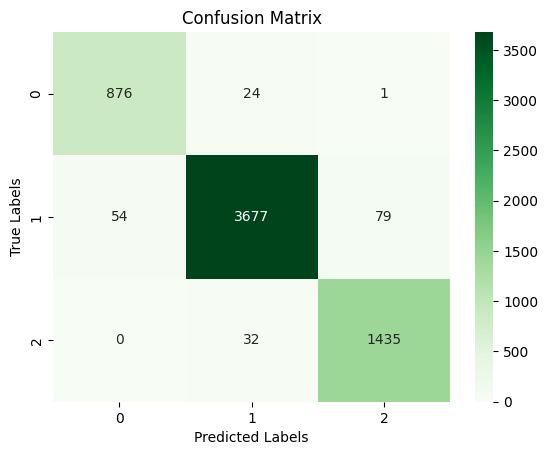

In [35]:
y_pred = rf_classifier.predict(X_test)
print("Random Forest")
# Evaluate the stacked model
evaluate_model(y_test, y_pred)


In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
# Initialize the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)

In [38]:
# Train the model
model.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(random_state=42)

In [40]:
# Make predictions on the test set
y_pred = model.predict(X_test)

Decision Tree Classifier
Classification Report
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       901
         1.0       0.97      0.96      0.97      3810
         2.0       0.93      0.96      0.94      1467

    accuracy                           0.96      6178
   macro avg       0.94      0.96      0.95      6178
weighted avg       0.96      0.96      0.96      6178


Accuracy:  0.9564584007769504
Precision:  0.9425075709047873
Recall:  0.9550969080050793
F1 Score:  0.9486378549922144


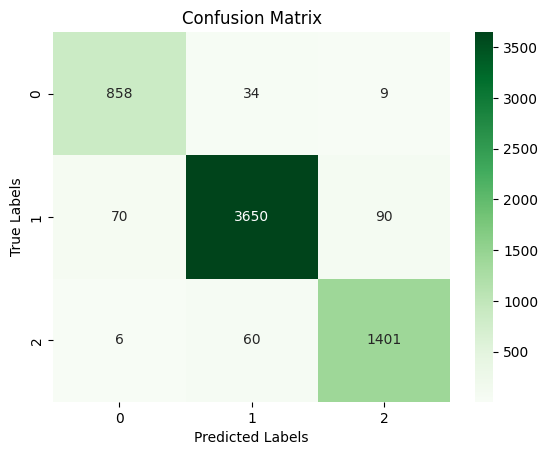

In [41]:
print("Decision Tree Classifier")
# Evaluate the stacked model
evaluate_model(y_test, y_pred)


In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
# Initialize the K-Nearest Neighbors Classifier
model = KNeighborsClassifier(n_neighbors=5)


In [44]:
# Train the model
model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = model.predict(X_test)

KNeighbors Classifier
Classification Report
              precision    recall  f1-score   support

         0.0       0.65      0.93      0.77       901
         1.0       0.94      0.77      0.85      3810
         2.0       0.74      0.89      0.81      1467

    accuracy                           0.82      6178
   macro avg       0.78      0.86      0.81      6178
weighted avg       0.85      0.82      0.83      6178


Accuracy:  0.8216251213985108
Precision:  0.7759189788804081
Recall:  0.8637197793369052
F1 Score:  0.8061327578511467


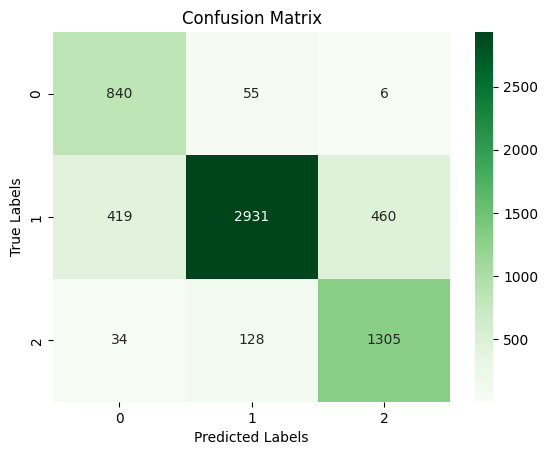

In [45]:
print("KNeighbors Classifier")
# Evaluate the stacked model
evaluate_model(y_test, y_pred)


In [46]:
from sklearn.naive_bayes import GaussianNB

In [47]:
# Initialize the Gaussian Naive Bayes Classifier
model = GaussianNB()


Naive Bayes Classifier
Classification Report
              precision    recall  f1-score   support

         0.0       0.37      0.33      0.35       901
         1.0       0.80      0.64      0.71      3810
         2.0       0.47      0.74      0.57      1467

    accuracy                           0.62      6178
   macro avg       0.55      0.57      0.55      6178
weighted avg       0.66      0.62      0.63      6178


Accuracy:  0.6207510521204274
Precision:  0.5470153058281007
Recall:  0.5707470076836438
F1 Score:  0.5459155011544239


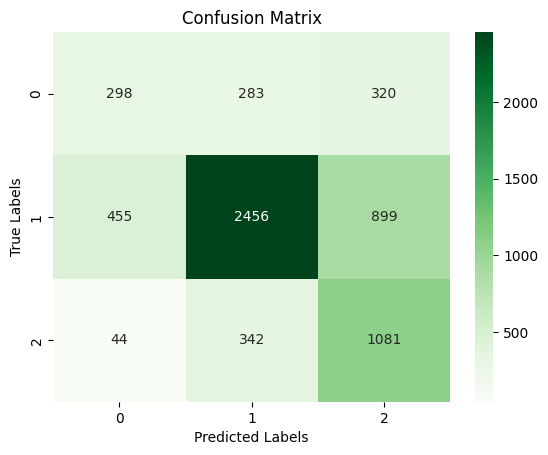

In [49]:
# Train the model
model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = model.predict(X_test)
print("Naive Bayes Classifier")
# Evaluate the stacked model
evaluate_model(y_test, y_pred)


In [50]:
from xgboost import XGBClassifier

In [51]:
# Initialize the XGBoost Classifier
model = XGBClassifier(random_state=42)

Classification Report
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       901
         1.0       0.90      0.86      0.88      3810
         2.0       0.76      0.87      0.82      1467

    accuracy                           0.85      6178
   macro avg       0.82      0.84      0.83      6178
weighted avg       0.85      0.85      0.85      6178


Accuracy:  0.8499514405956621
Precision:  0.8202672258292069
Recall:  0.8389526595042947
F1 Score:  0.828153180152948


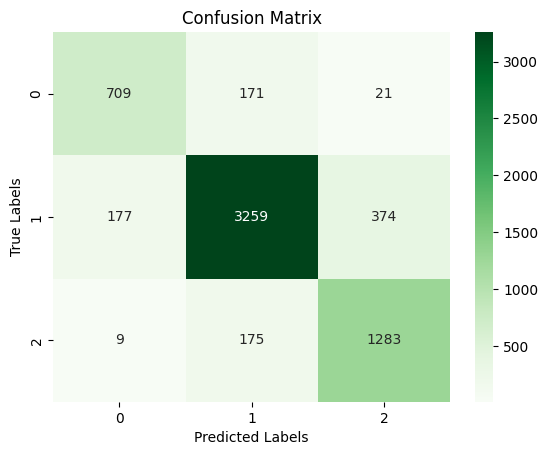

In [58]:
# Train the model
model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = model.predict(X_test)
print("XGBClassifier Classifier")
# Evaluate the stacked model
evaluate_model(y_test, y_pred)
